In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('BA', data_source='yahoo',start='2012-01-01', end='2022-03-07')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,75.000000,74.120003,74.699997,74.220001,6859300.0,60.731094
2012-01-04,74.599998,73.589996,74.099998,74.330002,4923000.0,60.821095
2012-01-05,73.900002,72.739998,73.769997,73.529999,6797900.0,60.166496
2012-01-06,74.269997,72.949997,73.730003,73.980003,4779800.0,60.534698
2012-01-09,74.870003,74.180000,74.809998,74.529999,4469600.0,60.984760
...,...,...,...,...,...,...
2022-03-01,203.500000,192.929993,203.110001,194.910004,11799500.0,194.910004
2022-03-02,199.850006,194.639999,196.270004,197.809998,7463400.0,197.809998
2022-03-03,198.500000,188.710007,197.940002,188.850006,12424500.0,188.850006


In [3]:
data = df.filter(['Close'])
dataset=data.values
training_data_len = math.ceil(len(dataset)*.81)
training_data_len

2075

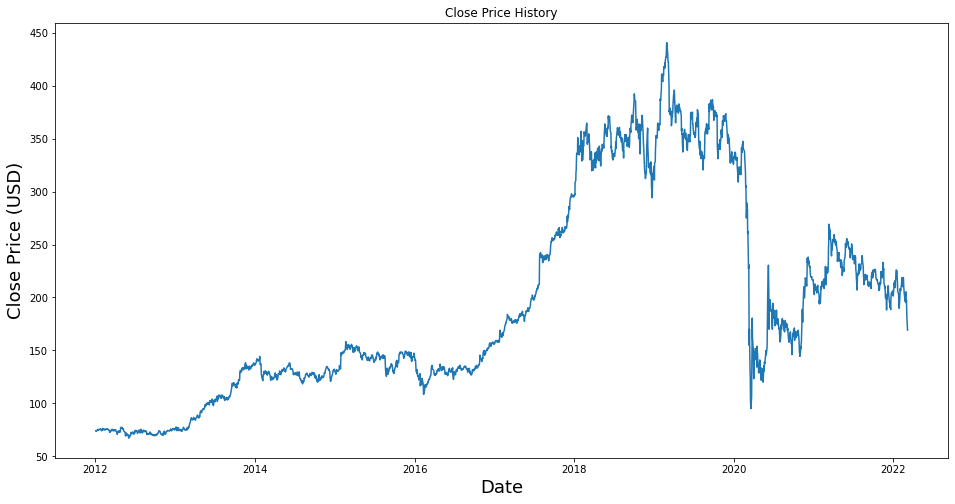

In [4]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0186941 ],
       [0.01898871],
       [0.01684611],
       ...,
       [0.32570038],
       [0.30424768],
       [0.27299266]])

In [6]:
train_data = scaled_data[0:training_data_len , :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.0186941 , 0.01898871, 0.01684611, 0.01805133, 0.01952435,
       0.02078312, 0.02008678, 0.02214903, 0.01971182, 0.02142589,
       0.02094381, 0.02228293, 0.0221758 , 0.02214903, 0.02174729,
       0.02297928, 0.02161337, 0.01957792, 0.01853341, 0.01858697,
       0.02177408, 0.02137234, 0.02437195, 0.02201511, 0.02131876,
       0.02201511, 0.02319354, 0.0206492 , 0.02038138, 0.02228293,
       0.02134555, 0.02150624, 0.0217205 , 0.02271146, 0.02362205,
       0.02305962, 0.02362205, 0.02134555, 0.02121165, 0.0206492 ,
       0.02099739, 0.0205153 , 0.01845305, 0.01424822, 0.01681932,
       0.01856018, 0.01620334, 0.01703359, 0.01893513, 0.02139913,
       0.02193476, 0.02131876, 0.02185442, 0.02115807, 0.02080991,
       0.01789062, 0.01802454, 0.02126521, 0.02027425, 0.01898871])]
[0.018319149439177812]



In [7]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1], 1))
x_train.shape

(2015, 60, 1)

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [11]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2015/2015 [==============================] - 38s 18ms/step - loss: 0.0020


In [12]:
test_data = scaled_data[training_data_len-60: , :]
x_test=[]
y_test=dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [13]:
x_test = np.array(x_test)

In [14]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [16]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

3.9920880980942965

C:\Users\kapoo\AppData\Local\Temp/ipykernel_14616/2133332622.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


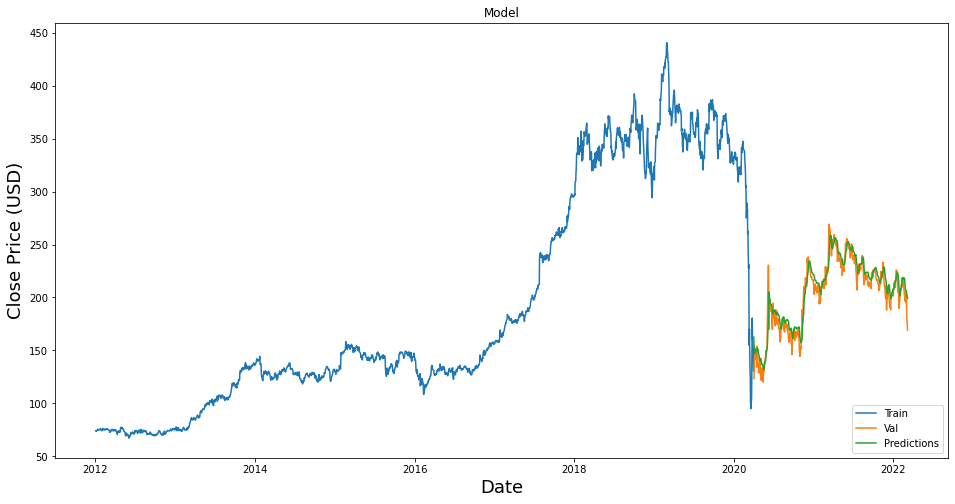

In [17]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc ='lower right')
plt.show()

In [18]:
valid

,Close,Predictions
Date,,
2020-04-02,123.269997,162.532455
2020-04-03,124.519997,155.873154
2020-04-06,148.770004,149.156601
2020-04-07,141.580002,147.240356
2020-04-08,146.869995,146.688416
...,...,...
2022-03-01,194.910004,206.250366
2022-03-02,197.809998,205.267868
2022-03-03,188.850006,204.525726


In [19]:
ba_quote = web.DataReader('BA', data_source='yahoo',start='2012-01-01', end='2022-03-07')
new_df = ba_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[193.66718]]


In [20]:
ba_quote2 = web.DataReader('BA', data_source='yahoo',start='2022-03-01', end='2022-03-07')
print(ba_quote2['Close'])

Date
2022-02-28    205.339996
2022-03-01    194.910004
2022-03-02    197.809998
2022-03-03    188.850006
2022-03-04    180.839996
2022-03-07    169.169998
Name: Close, dtype: float64
